# Part 1 - Exploratory Data Analysis (EDA)

We will start with an Exploratory Data Analysis (EDA) of our SF housing dataset.  
It is always a good idea to start with an EDA before designing and training a machine learning algorithm.  
EDA gives us better insight to the data by using statistical and visualization techniques.  

Upon completing this notebook, we should have:  
* Familiarity with [Pandas] and [NumPy] for data management and analysis
* Familiarity with [Matplotlib] and [seaborn] for visualization
* A decent understanding of the characteristics of our dataset
[Pandas]: https://pandas.pydata.org/
[NumPy]: http://www.numpy.org/
[Matplotlib]: https://matplotlib.org/
[seaborn]: https://seaborn.pydata.org/

In [142]:
import glob
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import Nominatim
import geojson
import folium
from branca.colormap import LinearColormap, StepColormap

%matplotlib inline

## Let's start by loading the data and have a peek at the contents 
The data was scraped from [zillow.com](https://www.zillow.com/) and is dispersed between several csv files. We use Pandas to load the csv files and concatenate them into a single DataFrame

In [143]:
all_csvs = []
# load the csv files from all scraping runs
for filename in glob.glob('./data/sf/**/*.csv'):
    all_csvs.append(pd.read_csv(filename))
# combine all dataframes together and drop any duplicate entries
df_raw = pd.concat(all_csvs, ignore_index=True).drop_duplicates()
# save this combined dataframe as csv for safe keeping
df_raw.to_csv('./data/sf/data_raw.csv', index=False)
# display first 5 entries of DataFrame
df_raw.head(5) 

,title,address,city,state,postal_code,price,facts and features,real estate provider,url
0,Condo For Sale,550 Davis St UNIT 44,San Francisco,CA,94111,"$1,995,000","3 bds , 2 ba , 1,520 sqft",Sotheby's International Realty,https://www.zillow.com/homedetails/550-Davis-S...
1,Condo For Sale,240 Lombard St APT 437,San Francisco,CA,94111,"$625,000","1 bd , 1 ba , 566 sqft",SimpleListing.com,https://www.zillow.com/homedetails/240-Lombard...
2,Condo For Sale,550 Davis St UNIT 39,San Francisco,CA,94111,"$1,196,000","1 bd , 1 ba , 914 sqft",NaN,https://www.zillow.com/homedetails/550-Davis-S...
3,Condo For Sale,77 Dow Pl APT 701,San Francisco,CA,94107,"$935,000","1 bd , 1.5 ba , 1,022 sqft",Vanguard Properties,https://www.zillow.com/homedetails/77-Dow-Pl-A...
4,House For Sale,807 Francisco St,San Francisco,CA,94109,"$16,900,000","6 bds , 6.5 ba , 6,180 sqft",Compass,https://www.zillow.com/homedetails/807-Francis...


### Our data is now contained in a variable named `df_raw` which is a pandas DataFrame.

## Display some quick stats about the DataFrame
DataFrame has a few built in functions we can call to get a quick summary of the data:  
* `info()` displays a count of all non-null objects and their datatypes  
* `describe()` calculates basic statistics about all numerical values in the DataFrame

In [144]:
df_raw.info()
df_raw.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538 entries, 0 to 839
Data columns (total 9 columns):
title                   538 non-null object
address                 538 non-null object
city                    538 non-null object
state                   538 non-null object
postal_code             538 non-null object
price                   537 non-null object
facts and features      538 non-null object
real estate provider    417 non-null object
url                     538 non-null object
dtypes: object(9)
memory usage: 42.0+ KB


,title,address,city,state,postal_code,price,facts and features,real estate provider,url
count,538,538,538,538,538,537,538,417,538
unique,11,521,6,1,27,314,478,110,522
top,Condo For Sale,1315 39th Ave,San Francisco,CA,94109,"$1,495,000","1 bd , 1 ba , -- sqft",Zephyr Real Estate,https://www.zillow.com/homedetails/77-Dow-Pl-A...
freq,211,2,494,538,40,13,7,42,2


Our `describe()` method does not yet have any numerical data to describe for us.

Notice that a lot of the columns which provide numerical data are not in a format ready for consumption.  
For instance the `price` columns contain `$` and `,` characters and the `facts and features` column has valuable information about number of beds, bath and square footage embedded within the text.  
  
Let's parse and format these columns.

In [145]:
# copy our original dataframe for safe keeping. We will manipulate `df` instead
df = df_raw.copy()

## Reformat price column
Time to use some convenient Pandas functions such as `.apply()` to apply a user defined formatting function to all values in a column.  

Remove `$` and `,` characters and format as `int`.  
Also, some prices are represented as `$1K` and `$1M` so let's replace with `1000` and `1000000`

In [146]:
import re
def format_price(price):
    """Remove all non-numerical"""
    price = str(price)
    multiply_factor = 1
    if 'M' in price:
        multiply_factor = 1e6
    elif 'K' in price:
        multiply_factor = 1e3
    non_decimal = re.compile(r'[^0-9\.]')
    price_num = None
    try:
        price_num = float(non_decimal.sub('', price))*multiply_factor
    except Exception as e:
#         print(f'error converting \"{price}\": {e}')
        pass
    finally:
        return price_num

# replace the values in the price column with the formatted price
df['price'] = df.price.apply(format_price)

## Parse `facts and features` column into multiple columns 
An example entry in this column: `3 bds , 2 ba , 1,520 sqft`  
Parse the text using comma followed by a space '`, `' as the delimiter so that we can still capture the comma in the square footage.

In [147]:
# TODO: consider studio as 0 beds?
non_decimal = re.compile(r'[^\d.]+')
def parse_beds(string):
    strings = string.lower().split(', ')
    num_beds = None
    for s in strings:
        if "bd" in s:
            try:
                num_beds = float(non_decimal.sub('', s))
            except Exception as e:
#                 print(s, e)
                pass
        # treat studio as 0 bedrooms
        elif "studio" in s.lower():
            num_beds = 0
        return num_beds

def parse_bath(string):
    strings = string.lower().split(', ')
    num_bath = None
    for s in strings:
        if "ba" in s:
            try:
                num_bath = float(non_decimal.sub('', s))
            except Exception as e:
#                 print(s, e)
                pass
            finally:
#                 print(f'num_bath = {num_bath}')
                return num_bath
def parse_sqft(string):
    strings = string.lower().split(', ')
    sqft = None
    for s in strings:
        if "ft" in s:
            try:
                sqft = float(non_decimal.sub('', s))
            except Exception as e:
#                 print(s, e)
                pass
            finally:
#                 print(f'sqft = {sqft}')
                return sqft
df['bed'] = df['facts and features'].apply(parse_beds)
df['bath'] = df['facts and features'].apply(parse_bath)
df['sqft'] = df['facts and features'].apply(parse_sqft)

## Parse `title` column into `property_type`
The title of the posting contains some information we can parse. For instance we can map `'Condo For Sale'` --> `condo`

First let's see if there is a pattern to the titles:

In [148]:
print(df.title.unique())
print(df.title.value_counts())

['Condo For Sale' 'House For Sale' 'Apartment For Sale' 'New Construction'
 'Foreclosure' 'Lot/Land For Sale' 'Coming Soon' 'Co-op For Sale'
 'Auction' 'For Sale by Owner' 'Townhouse For Sale']
Condo For Sale        211
House For Sale        150
Apartment For Sale    100
New Construction       37
Coming Soon            12
Lot/Land For Sale       9
Auction                 6
For Sale by Owner       6
Co-op For Sale          5
Townhouse For Sale      1
Foreclosure             1
Name: title, dtype: int64


Looks like there is a limited amount of unique values, which is good. We can design our parser to catch most cases.  
We won't parse 'For Sale by Owner' since it is too vague

In [149]:
# map property types
property_types = {'Condo For Sale': 'condo', 
                  'House For Sale': 'house', 
                  'Apartment For Sale': 'apartment', 
                  'New Construction': 'new',
                  'Foreclosure': 'foreclosure', 
                   'Lot/Land For Sale': 'lot', 
                  'Coming Soon': 'coming', 
                  'Co-op For Sale': 'coop',
                  'Auction': 'auction', 
                  'For Sale by Owner': None, 
                  'Townhouse For Sale': 'townhouse'}
def parse_property_type(string):
    try:
        property_type = property_types[string]
    except KeyError as e:
        print(e)
        property_type = None
    finally:
        return property_type
df['property_type'] = df['title'].apply(parse_property_type)

In [150]:
df.property_type.value_counts()

condo          211
house          150
apartment      100
new             37
coming          12
lot              9
auction          6
coop             5
foreclosure      1
townhouse        1
Name: property_type, dtype: int64

If we check the `info()` of the dataframe, we should see some columns are now numerical

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538 entries, 0 to 839
Data columns (total 13 columns):
title                   538 non-null object
address                 538 non-null object
city                    538 non-null object
state                   538 non-null object
postal_code             538 non-null object
price                   537 non-null float64
facts and features      538 non-null object
real estate provider    417 non-null object
url                     538 non-null object
bed                     525 non-null float64
bath                    438 non-null float64
sqft                    489 non-null float64
property_type           532 non-null object
dtypes: float64(4), object(9)
memory usage: 58.8+ KB


Now we can call `describe()` to get some stats about the numerical values

In [152]:
df.describe()

,price,bed,bath,sqft
count,5.370000e+02,525.000000,438.000000,489.000000
mean,2.231162e+06,2.062857,2.150685,2195.202454
std,2.627530e+06,1.599693,1.333690,1952.270962
min,2.000000e+05,0.000000,1.000000,1.000000
25%,9.400000e+05,1.000000,1.000000,1067.000000
50%,1.465000e+06,2.000000,2.000000,1582.000000
75%,2.295000e+06,3.000000,2.500000,2500.000000
max,2.500000e+07,10.000000,11.000000,15039.000000


### Very large maximum price albeit not suprising. 

In [153]:
# describe only the 'price' column
df['price'].describe()

count    5.370000e+02
mean     2.231162e+06
std      2.627530e+06
min      2.000000e+05
25%      9.400000e+05
50%      1.465000e+06
75%      2.295000e+06
max      2.500000e+07
Name: price, dtype: float64

## We have the gist of the dataset size and its contents, it's time to go more in depth and Visualize the data.  
We will use `Seaborn` to visualize the data.

# TODO: consider PCA for visualizing high dimensional data

### Plot histogram of prices

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


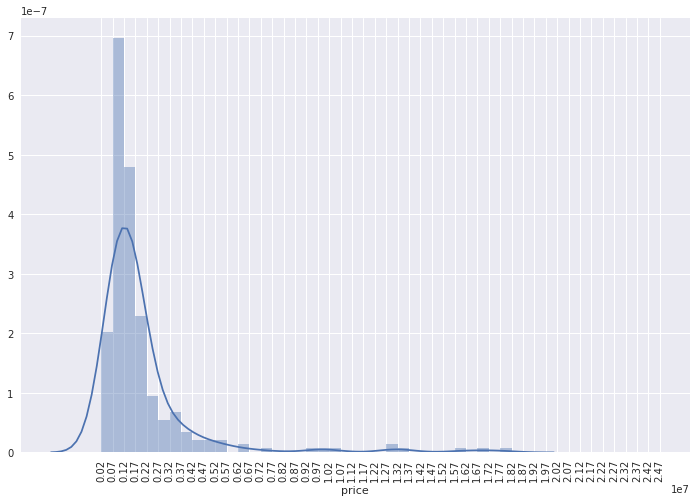

In [154]:
# globally set our seaborn plot size to 12 by 8 inches:
sns.set(rc={'figure.figsize':(12, 8)})

def plot_prices(df: pd.DataFrame, bins: list):
    fig, ax = plt.subplots()
    ax.set_xticks(bins)
    plt.xticks(rotation='vertical')
    return sns.distplot(df.price, bins=bins)

bins = range(int(df.price.min()), int(df.price.max()), 500000)
plot_prices(df.dropna(), bins)

### Definitely a skewed distribution, looks as if we have a few outliers at the higher range of the prices.  
### We can quantify this by calculating:  
* `Skewness` - A measure of the symmetry (or lack thereof) of a distribution
* `Kurtosis` - Whether distrubition is "heavy-tailed" or "light-tailed" or in other words: how "sharp" the peak is.

In [155]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

Skewness: 4.099974
Kurtosis: 22.026335


## Plot with outliers removed

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Skewness (outliers removed): 1.938085
Kurtosis (outliers removed): 3.829789


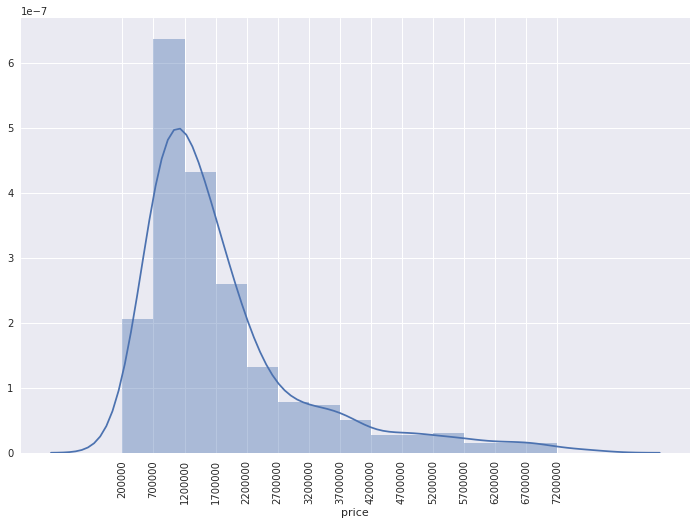

In [156]:
df_no_outliers = df[df.price < 8e6]
bins = range(int(df_no_outliers.price.min()),int(df_no_outliers.price.max()),500000)
plot_prices(df_no_outliers, bins)
print("Skewness (outliers removed): %f" % df_no_outliers['price'].skew())
print("Kurtosis (outliers removed): %f" % df_no_outliers['price'].kurt())

### Removing the outliers improved our skewness and kurtosis values.
We will remember this when cleaning the data for our model. Machine learning models work best with normally distributed data. Outliers may affect model performance.

## Plot missing values.
Recall that there were some columns which are incomplete. Plot a bar graph describing this:

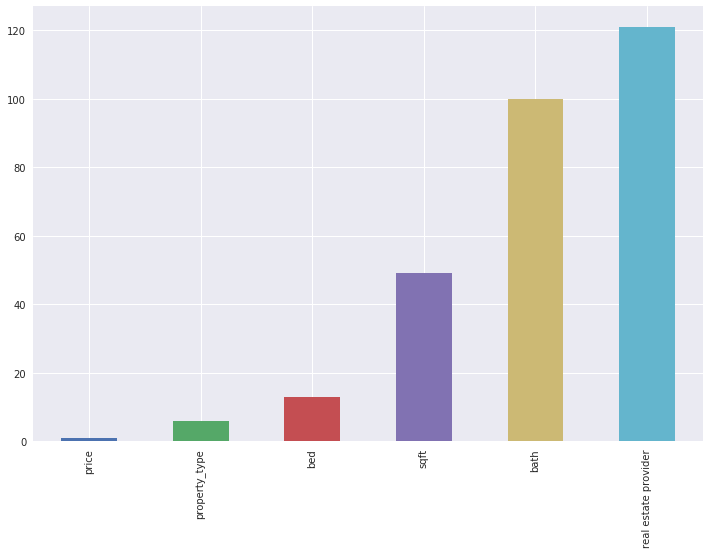

In [157]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

Variables that are missing values can either be removed from the dataset or have their missing values replaced (perhaps with 0 or the mean of the column). Remember this for data cleaning.

## Visualize the house prices w.r.t location with a slippy map  
We have some location information in the '`address`' column. We'll use geocoding to convert the string address to Lat Long.  

In [158]:
from IPython.display import clear_output
from geopy.geocoders import Nominatim
def generate_latlng(dataframe: pd.DataFrame):
    dataframe = dataframe.copy()
    geocoder = Nominatim()
    latlngs = []
    for address, city in zip(dataframe.address, dataframe.city):
        clear_output(wait=True)
        print(f'{len(latlngs)+1}/{len(dataframe)} complete...')
        location = geocoder.geocode(f'{address} {city}')
        if location:
            latlngs.append((location.latitude, location.longitude))
        else:
            latlngs.append(None)
    dataframe['latlng'] = latlngs
    return dataframe

The above function `generate_latlng()` takes a while to run since we call a web service `Nominatim` to perform the address --> latlng conversion.  
Let's use Python's `multiprocessing` module to run these conversions in a background job.

In [159]:
from multiprocessing import Pool
pool = Pool()
job = pool.apply_async(func=generate_latlng, args=(df,))

538/538 complete...



We can check whether the job is complete using `ready()`

In [166]:
if job.ready():
    df = job.get()
else:
    print("job not complete yet")

In [167]:
df.head(10)

,title,address,city,state,postal_code,price,facts and features,real estate provider,url,bed,bath,sqft,property_type,latlng
0,Condo For Sale,550 Davis St UNIT 44,San Francisco,CA,94111,1995000.0,"3 bds , 2 ba , 1,520 sqft",Sotheby's International Realty,https://www.zillow.com/homedetails/550-Davis-S...,3.0,2.0,1520.0,condo,None
1,Condo For Sale,240 Lombard St APT 437,San Francisco,CA,94111,625000.0,"1 bd , 1 ba , 566 sqft",SimpleListing.com,https://www.zillow.com/homedetails/240-Lombard...,1.0,1.0,566.0,condo,None
2,Condo For Sale,550 Davis St UNIT 39,San Francisco,CA,94111,1196000.0,"1 bd , 1 ba , 914 sqft",NaN,https://www.zillow.com/homedetails/550-Davis-S...,1.0,1.0,914.0,condo,None
3,Condo For Sale,77 Dow Pl APT 701,San Francisco,CA,94107,935000.0,"1 bd , 1.5 ba , 1,022 sqft",Vanguard Properties,https://www.zillow.com/homedetails/77-Dow-Pl-A...,1.0,1.5,1022.0,condo,None
4,House For Sale,807 Francisco St,San Francisco,CA,94109,16900000.0,"6 bds , 6.5 ba , 6,180 sqft",Compass,https://www.zillow.com/homedetails/807-Francis...,6.0,6.5,6180.0,house,"(37.8038257453414, -122.41844925566)"
5,Condo For Sale,1310 1314 Greenwich St # 401,San Francisco,CA,94109,2750000.0,"2 bds , 2 ba , 1,912 sqft",Sotheby's International Realty,https://www.zillow.com/homedetails/1310-1314-G...,2.0,2.0,1912.0,condo,"(37.8008785510204, -122.421370040816)"
6,Apartment For Sale,1219 Kearny St,San Francisco,CA,94133,2550000.0,"Studio , -- ba , 3,240 sqft","TRI Investment Services, Inc.",https://www.zillow.com/homedetails/1219-Kearny...,0.0,NaN,3240.0,apartment,"(37.7992538461538, -122.405807653846)"
7,New Construction,1545 Pine St # U4I7Q,San Francisco,CA,94109,727500.0,"-- bds , 1 ba , 432+ sqft",NaN,https://www.zillow.com/community/austin/209252...,NaN,1.0,432.0,new,None
8,New Construction,1545 Pine St # KBU33O,San Francisco,CA,94109,842000.0,"1 bd , 1 ba , 630+ sqft",NaN,https://www.zillow.com/community/austin/209252...,1.0,1.0,630.0,new,None
9,Condo For Sale,301 Mission St APT 12A,San Francisco,CA,94105,2150000.0,"2 bds , 2 ba , 1,479 sqft",Pacific Union International Inc.,https://www.zillow.com/homedetails/301-Mission...,2.0,2.0,1479.0,condo,None


We use `folium` to render the slippy map in the notebook.  
Note that there are hundreds of houses to be displayed and this requires a fair bit of RAM. If your browser crashes you can adjust the amount to be displayed by changing the variable `display_max`.

In [100]:
def draw_houses_on_map(dataframe: pd.DataFrame):
    dataframe = dataframe.copy()
    # create a folium map object centered in SF
    m = folium.Map(location=(37.7, -122.4))
    # create a colormap of the prices (we limit prices between 5e5 and 10e6)
    colors = ['gray', 'green','blue','red','orange', 'yellow']
    min_price, max_price = 5e5, 6e6
    colormap = StepColormap(colors=colors,vmin=min_price, vmax=max_price, caption='price')
    m.add_child(colormap)
    # amount of points to render on the map. WARNING: significant RAM required to plot all points and may crash your browser 
    display_max = len(dataframe) # plot all
    # display_max = 100 # uncomment and adjust this number if needed
    displayed = 0
    for i, latlng in zip(dataframe.index, dataframe['latlng']):
        price = dataframe.loc[i, 'price']
        if latlng is not None and latlng != 'MISSING':
            if isinstance(latlng, str):
                lat, lng = latlng.replace('(','').replace(')','').split(',')
                latlng = (float(lat), float(lng))
            if not isinstance(latlng, tuple):
                continue
            style = {'fillColor': colormap(price),
                    'color' : colormap(price)}
            p = geojson.Point(coordinates=(latlng[1], latlng[0]), style=style)
            # build an HTML string to be displayed if we click a marker.
            html_info = '<li>Price: ${}</li><li>Property Type: {}</li>'.format(dataframe.loc[i, 'price'], dataframe.loc[i, 'property_type'])
            m.add_child(folium.Marker(location=latlng, icon=folium.Icon(color='black', icon_color=colormap(price)), popup=folium.Popup(html=html_info)))
            displayed += 1
            if displayed > display_max:
                break
    return m
draw_houses_on_map(df)

We can observe some patterns w.r.t. location.  
Seems the more expensive homes are Central and North and the "lower" (finger quotes) priced homes on the outside

## Next, let's see how some of the variables interact with the list price.  
Since `price` is our target variable (the variable we are trying to predict), it is useful visualize how each variable relates to `price`. 

### sqft
Total square footage

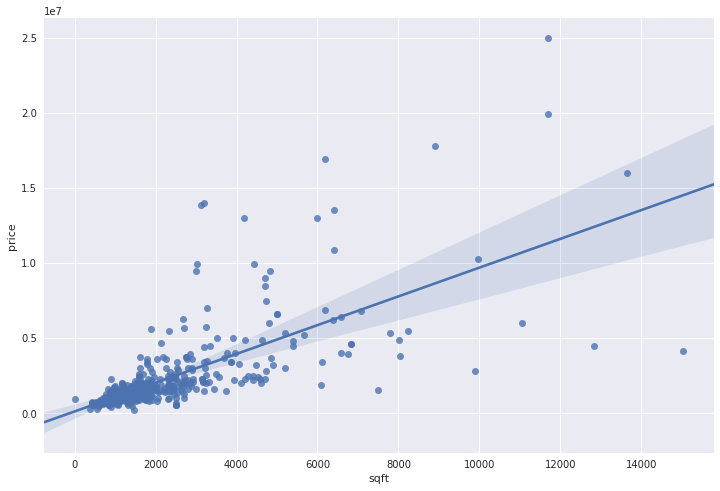

In [161]:
# sqft/saleprice
var = 'sqft'
sns.regplot(df[var], df['price'], )

The relationship looks linear with some spreading as sqft increases. We can also see there are some houses with almost zero square feet! Let's investigate why:  
  
Note on `pandas.DataFrame` indexing:  
* `df['sqft'] < condition` gives us a "truth array" where True values match the condition and False otherwise. If we index the original DataFrame with this truth array we get a filtered result

In [162]:
# filter the DataFrame with nearly zero sqft
df[df['sqft'] < 10].head()

,title,address,city,state,postal_code,price,facts and features,real estate provider,url,bed,bath,sqft,property_type
360,Condo For Sale,338 Spear St UNIT 15G,San Francisco,CA,94105,949000.0,"1 bd , 1 ba , 1 sqft",Paragon Real Estate Group,https://www.zillow.com/homedetails/338-Spear-S...,1.0,1.0,1.0,condo


Looks like we have some bad data from the web scraping. We will remember to remove these when we get to our data cleaning notebook

### bed
Number of bedrooms

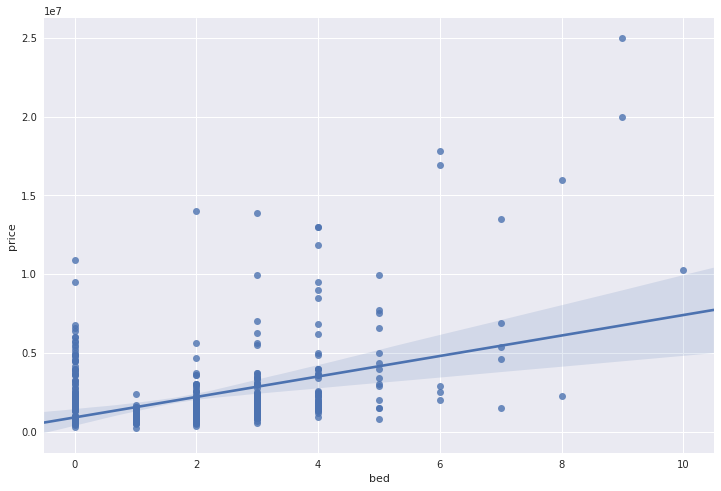

In [163]:
var = 'bed'
sns.regplot(df[var], df['price'], )

We observe a bit of a positive correlation between price and number of beds

### bath
Number of bathrooms

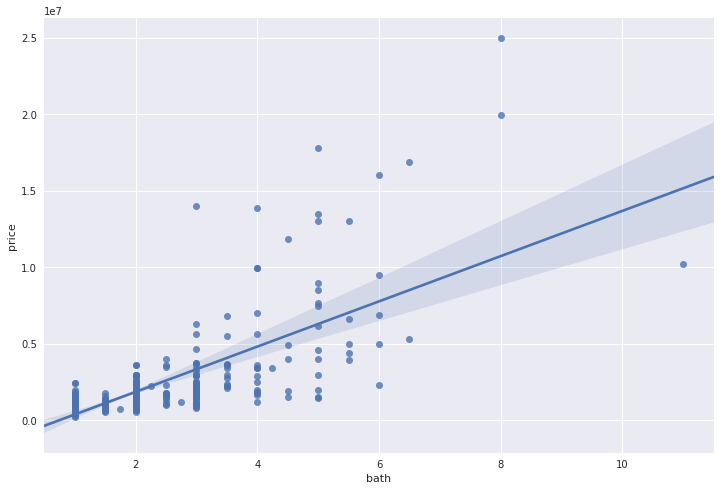

In [164]:
var = 'bath'
sns.regplot(df[var], df['price'], )

Positive correlation between number of baths and price

## Generate a correlation matrix

A correlation matrix will graphically show us which variables are most correlated to our target variable `price`.
In this case a positive correlation means as we increase the variable, the price increases

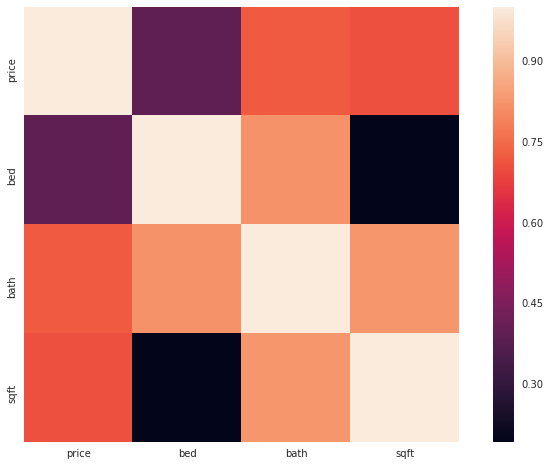

In [165]:
corrmat = df.corr()
sns.heatmap(corrmat, vmax=1, square=True);

Observe the `price` across a row or column to get an idea which variables are most likely to correlate to price.

## Categorical Variables.  
So far we have only dealt with numeric variables however there are several non-numerical (**Categorical**) variables to be investigated as well.  
Categorical variables are ones which provide information but are not quantified numerically. For instance, the `postal_code` variable gives us information about what neighbourhood the house is located and from our map plot, we found this information is important when considering house prices.  
In order to use these categorical variables in our model, we encode them into a numerical representation called a [Dummy Variable]. We cover Dummy Variables in a later notebook.
[Dummy Variable]: https://en.wikipedia.org/wiki/Dummy_variable_(statistics)

In [106]:
print(df.columns)

Index(['title', 'address', 'city', 'state', 'postal_code', 'price',
       'facts and features', 'real estate provider', 'url', 'bed', 'bath',
       'sqft', 'property_type', 'latlng'],
      dtype='object')


Let's choose `property_type`, and `postal_code` to investigate.  
We can use the `unique()` function on the categorical columns to see the different categories.

In [107]:
print(df['postal_code'].value_counts())
print(df['property_type'].unique())

94109    40
94115    36
94107    33
94114    33
94110    32
94112    31
94131    30
94121    30
94118    29
94105    29
94124    28
94103    26
94123    26
94133    26
94122    23
94117    20
94116    15
94127    14
94102    12
94108     9
94104     6
94111     5
94501     1
94608     1
94607     1
94005     1
94014     1
Name: postal_code, dtype: int64
['condo' 'house' 'apartment' 'new' 'foreclosure' 'lot' 'coming' 'coop'
 'auction' None 'townhouse']


There are some variables with only a single value, let's get rid of that data.

In [41]:
postal_codes = ['94501',
'94608',
'94607',
'94005',
'94014',]
for postal_code in postal_codes:
    df = df[df.postal_code != int(postal_code)]
property_types = ['townhouse', 'foreclosure']
for property_type in property_types:
    df = df[df.property_type != property_type]
print(df['postal_code'].value_counts())
print(df['property_type'].value_counts())

94109    40
94115    36
94114    33
94107    33
94110    32
94112    30
94121    30
94131    30
94105    29
94118    29
94124    28
94103    26
94133    26
94123    26
94122    22
94117    20
94116    15
94127    14
94102    12
94108     9
94104     6
94111     5
Name: postal_code, dtype: int64
condo        211
house        147
apartment    100
new           36
coming        11
lot            9
auction        6
coop           5
Name: property_type, dtype: int64


Visualize these categories as box plots.  
We use the `pandas.melt()` function to flatten our variables into a single column so we can plot.  
The result of using `melt()` is most easily understood by displaying the result.

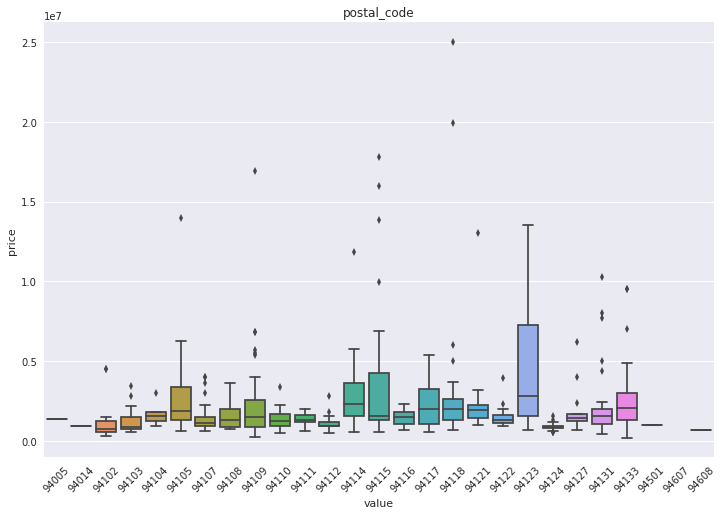

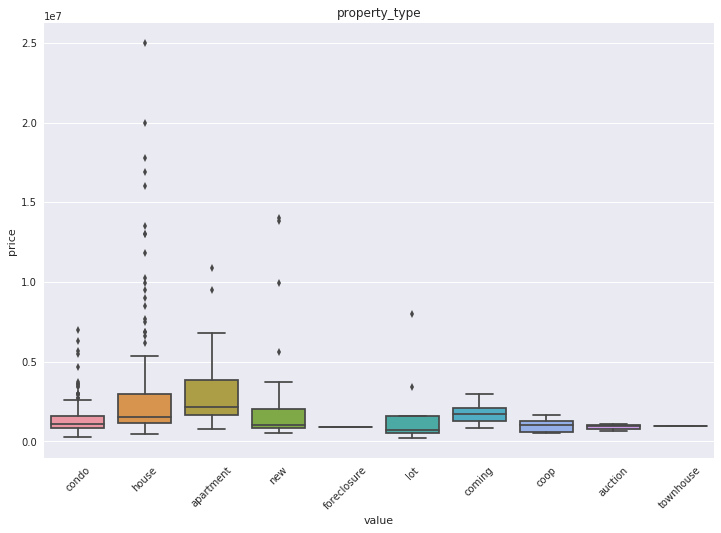

In [108]:
vars_to_analyze = ['postal_code', 'property_type']
df_melt = pd.melt(df, id_vars=['price'], value_vars=vars_to_analyze)
for var in vars_to_analyze:
    df_var = df_melt[df_melt['variable'] == var]
    sns.boxplot(x=df_var['value'], y=df_var['price'])
    x=plt.xticks(rotation=45)
    plt.title(var)
    plt.show()

## Analysis of variance (ANOVA)
We use ANOVA to explore how much variance occurs **between** groups (ie. *[price vs sub_area]* vs *[price vs area]* vs *[price vs property_type]* vs *[price vs strata_type]*) versus how much variance occurs **within** each group (ie *price vs sub_area* alone).  
In the end this tells us is how useful it will be to group `price` into these 4 groups (and if including each variable in our model is useful to us).  
Here's a quick YouTube video that may better explain ANOVA:  

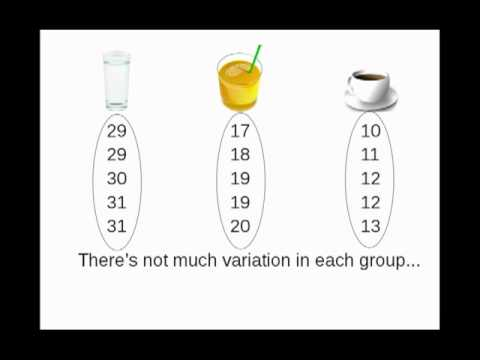

In [109]:
from IPython.display import YouTubeVideo
YouTubeVideo(id='ITf4vHhyGpc')

[array([16900000.,  2750000.,  5350000.,  1995000.]), array([1199000.,  788888.,  749000., 1795000.,  789000.,  949000.,
       1299000., 1050000.,  949888.,  899000.,  899000.,  849000.,
        499000., 1100000., 1520000., 1499000.,  699000., 1395000.,
       1560000.,  949000.,  949000., 1195000.,  895000., 1199000.]), array([ 4385000.,  1349000.,  1599000.,  1195000.,  1599000., 10250000.,
        2429000.,  1995000.,  1995000.,   825000.,  1595000.]), array([1150000., 1395000., 1795000., 1750000.]), array([2499000., 1895000., 2250000., 1295000., 2995000., 1595000.,
       1995000., 1395000., 1795000., 1250000., 1899000.]), array([1695000., 1395000., 2395000., 3975000., 1498000., 1295000.,
       1425000., 1495000., 1199000.]), array([2195000.,  945555., 1795000.,  799000., 1076240.,  945555.,
        899000.,  819000.]), array([1445000., 1095000., 4599000., 3395000., 3395000.]), array([ 2250000., 13500000., 12995000.,  7500000.,  9950000.,  4895000.,
        6595000.,  1795000.,  

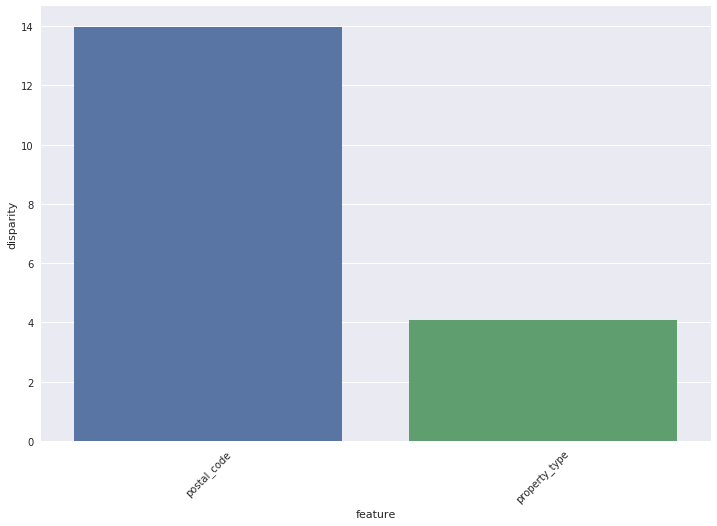

In [110]:
def anova(df):
    anv = pd.DataFrame()
    anv['feature'] = vars_to_analyze
    pvals = []
#     import pdb; pdb.set_trace()
    for c in vars_to_analyze:
        samples = []
        for cls in df[c].unique():
            s = df[df[c] == cls]['price'].values
            samples.append(s)
        try:
            pval = stats.f_oneway(*samples)[1]
        except Exception as e:
            pval=None
            print(e)
        finally:
            pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(df.dropna())
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=45)

This gives us a rough estimate of effect each variable will have on our model.

# Save our DataFrame to .csv

In [168]:
df.to_csv('./data/sf/data.csv', index=False)

## Hopefully the EDA has improved our intuition about the dataset. Now we can move onto data cleaning!